In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

from torch import optim
import torch.nn.functional as F

In [1]:
classes = ['#', '$', '&', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
           '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
           'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
print(classes)

['#', '$', '&', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [4]:
train_annot = pd.read_csv(r'annotations/hwr_train_annotations.csv')
val_annot = pd.read_csv(r'annotations/hwr_test_annotations.csv')
train_annot.head()

,Image_path,Label
0,###_1000.png,0
1,###_10000.png,0
2,###_10001.png,0
3,###_10002.png,0
4,###_10003.png,0


In [6]:


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

In [8]:
train_dataset = CustomImageDataset(
    annotations_file=r'annotations/hwr_train_annotations.csv',
    img_dir=r'Handwritten\Train',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [9]:
test_dataset = CustomImageDataset(
    annotations_file=r'annotations/hwr_test_annotations.csv',
    img_dir=r'Handwritten\Test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 32, 32])


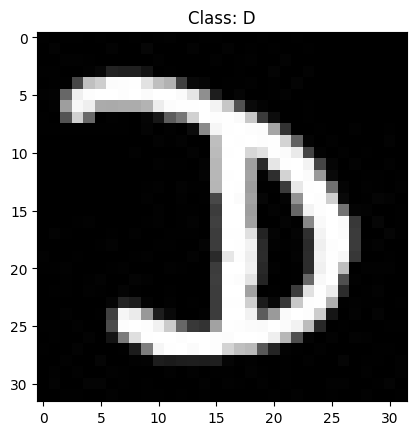

In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.title(f"Class: {classes[label]}")
plt.imshow(img, cmap="gray")
plt.show()

In [11]:


class ModifiedMNISTNet(nn.Module):
    def __init__(self):
        super(ModifiedMNISTNet, self).__init__()
        
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: [1, 32, 32], Output: [32, 32, 32]
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Output: [32, 16, 16]
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: [32, 16, 16], Output: [64, 16, 16]
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # Output: [64, 8, 8]
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: [64, 8, 8], Output: [128, 8, 8]
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # Output: [128, 4, 4]
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)  # Min dropout
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Input: [128 * 4 * 4], Output: [128]
        self.fc2 = nn.Linear(128, 64)  # Input: [128], Output: [64]
        self.fc3 = nn.Linear(64, 39)  # Output: [39] - number of classes
        
    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Forward pass through the second convolutional layer
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Forward pass through the third convolutional layer
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Apply dropout
        x = self.dropout(F.relu(self.fc1(x)))
        
        # Forward pass through the second fully connected layer
        x = F.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Instantiate the model
net = ModifiedMNISTNet()

# Print the model architecture
print(net)


ModifiedMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=39, bias=True)

In [29]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [18]:
net.apply(init_weights)

optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [34]:

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [5]:
batch_size = 64
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, net, criterion, optimizer)
    test_loop(test_loader, net, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.656662  [   64/834036]
loss: 0.385614  [ 6464/834036]
loss: 0.551124  [12864/834036]
loss: 0.315887  [19264/834036]
loss: 0.205226  [25664/834036]
loss: 0.266880  [32064/834036]
loss: 0.266612  [38464/834036]
loss: 0.225636  [44864/834036]
loss: 0.463806  [51264/834036]
loss: 0.285572  [57664/834036]
loss: 0.434262  [64064/834036]
loss: 0.419531  [70464/834036]
loss: 0.201219  [76864/834036]
loss: 0.201711  [83264/834036]
loss: 0.283371  [89664/834036]
loss: 0.199096  [96064/834036]
loss: 0.166504  [102464/834036]
loss: 0.245700  [108864/834036]
loss: 0.320926  [115264/834036]
loss: 0.264155  [121664/834036]
loss: 0.091086  [128064/834036]
loss: 0.238883  [134464/834036]
loss: 0.246490  [140864/834036]
loss: 0.265681  [147264/834036]
loss: 0.203207  [153664/834036]
loss: 0.238820  [160064/834036]
loss: 0.313618  [166464/834036]
loss: 0.320869  [172864/834036]
loss: 0.226165  [179264/834036]
loss: 0.230846  [185664/834036]
loss: 0.219416  

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, f1_score
import numpy as np

def evaluate(net, test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.view_as(pred).numpy())
            all_outputs.extend(output.numpy())

    # Calculate metrics
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

    # Classification report and F1-Score
    all_preds = np.argmax(all_outputs, axis=1)
    print(classification_report(all_targets, all_preds))
    print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))

    # ROC Curve for each class
    targets_one_hot = label_binarize(all_targets, classes=np.arange(39))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(39):
        fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], np.array(all_outputs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(16, 10))
    for i in range(39):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for Class: {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for each Category')
    plt.legend(loc="lower right")
    plt.show()





Test set: Average loss: 0.0023, Accuracy: 21478/22524 (95%)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1300
           1       1.00      1.00      1.00      1350
           2       1.00      1.00      1.00       520
           3       0.94      0.99      0.96       368
           4       0.91      0.95      0.93      1675
           5       0.97      0.98      0.98      1267
           6       1.00      0.99      1.00      1301
           7       0.99      0.97      0.98      1277
           8       1.00      0.96      0.98      1388
           9       0.97      0.99      0.98      1594
          10       0.95      0.99      0.97       190
          11       0.98      0.99      0.98      1198
          12       0.88      0.99      0.93      1195
          13       1.00      1.00      1.00      1250
          14       0.91      0.96      0.93       392
          15       0.95      0.91      0.93       385
          16       

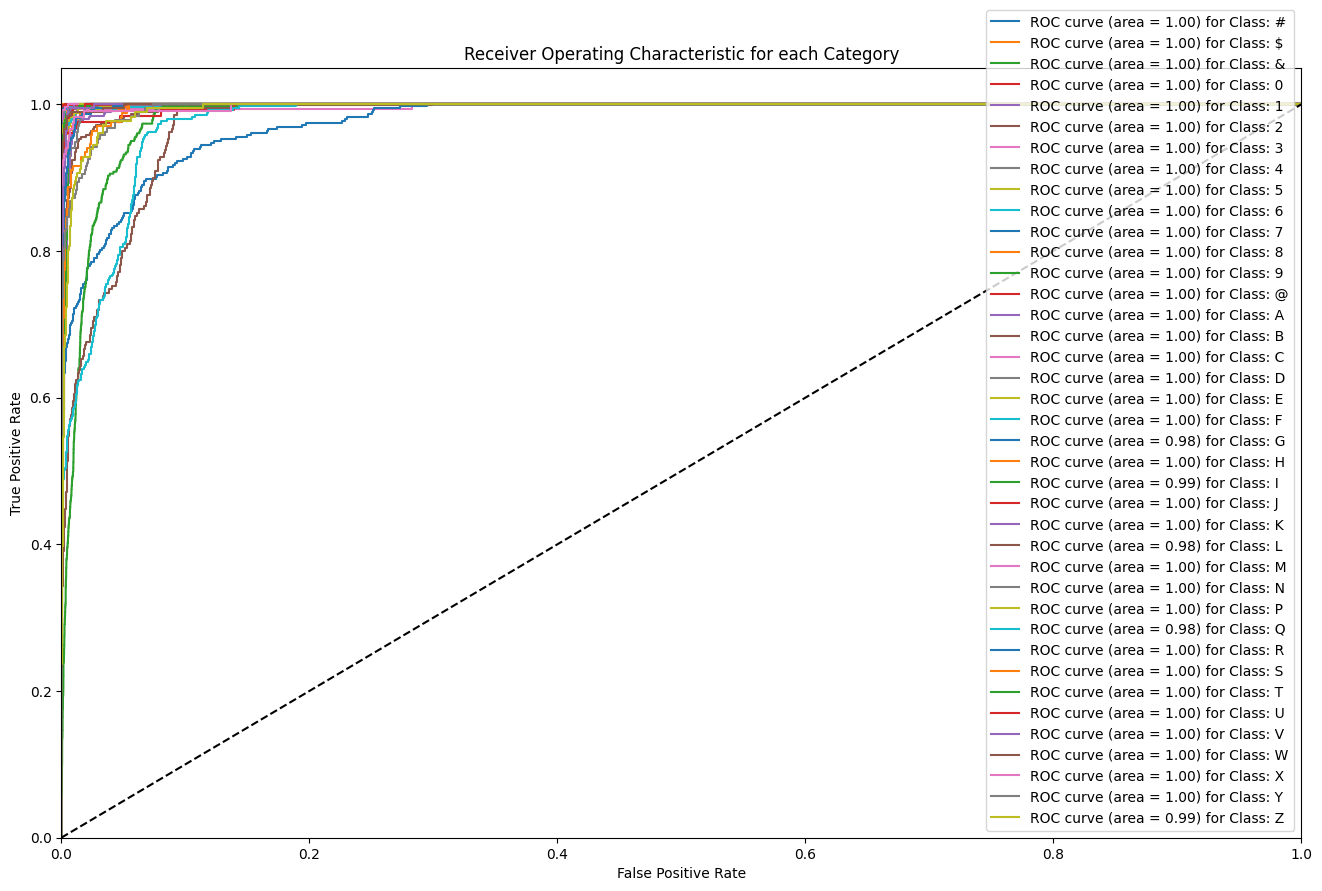

In [28]:
evaluate(net, test_loader)

In [31]:
net = model

In [32]:
path = r'Handwritten\Test'

transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])


for cls_ in classes:
    image_path = f'{path}\{cls_*2}_10050.png'
    
    X = read_image(image_path)

    X = transform(X)
    X = X.unsqueeze(0)  

    logits = net(X)
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    print(f"Actual Class: {cls_} | Predicted class:  {classes[y_pred.tolist()[0]]}")

Actual Class: # | Predicted class:  #
Actual Class: $ | Predicted class:  $
Actual Class: & | Predicted class:  &
Actual Class: 0 | Predicted class:  0
Actual Class: 1 | Predicted class:  1
Actual Class: 2 | Predicted class:  2
Actual Class: 3 | Predicted class:  3
Actual Class: 4 | Predicted class:  4
Actual Class: 5 | Predicted class:  5
Actual Class: 6 | Predicted class:  6
Actual Class: 7 | Predicted class:  7
Actual Class: 8 | Predicted class:  8
Actual Class: 9 | Predicted class:  9
Actual Class: @ | Predicted class:  @
Actual Class: A | Predicted class:  A
Actual Class: B | Predicted class:  B
Actual Class: C | Predicted class:  C
Actual Class: D | Predicted class:  0
Actual Class: E | Predicted class:  E
Actual Class: F | Predicted class:  F
Actual Class: G | Predicted class:  G
Actual Class: H | Predicted class:  H
Actual Class: I | Predicted class:  I
Actual Class: J | Predicted class:  J
Actual Class: K | Predicted class:  K
Actual Class: L | Predicted class:  L
Actual Class

In [52]:
net

ModifiedMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=39, bias=True)

In [53]:
torch.save(net, 'HWR_Model.pth')

In [12]:
model = torch.load('HWR_Model.pth')
model

C:\Users\user\AppData\Local\Temp\ipykernel_2064\1425506060.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('HWR_Modle_95.pth')


ModifiedMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=39, bias=True)

In [33]:
path = r'Handwritten\Test'

transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])


for cls_ in classes:
    image_path = f'{path}\{cls_*2}_10050.png'
    
    X = read_image(image_path)

    X = transform(X)
    X = X.unsqueeze(0)  

    logits = model(X)
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    print(f"Actual Class: {cls_} | Predicted class:  {classes[y_pred.tolist()[0]]}")

Actual Class: # | Predicted class:  #
Actual Class: $ | Predicted class:  $
Actual Class: & | Predicted class:  &
Actual Class: 0 | Predicted class:  0
Actual Class: 1 | Predicted class:  1
Actual Class: 2 | Predicted class:  2
Actual Class: 3 | Predicted class:  3
Actual Class: 4 | Predicted class:  4
Actual Class: 5 | Predicted class:  5
Actual Class: 6 | Predicted class:  6
Actual Class: 7 | Predicted class:  7
Actual Class: 8 | Predicted class:  8
Actual Class: 9 | Predicted class:  9
Actual Class: @ | Predicted class:  @
Actual Class: A | Predicted class:  A
Actual Class: B | Predicted class:  B
Actual Class: C | Predicted class:  C
Actual Class: D | Predicted class:  0
Actual Class: E | Predicted class:  E
Actual Class: F | Predicted class:  F
Actual Class: G | Predicted class:  G
Actual Class: H | Predicted class:  H
Actual Class: I | Predicted class:  I
Actual Class: J | Predicted class:  J
Actual Class: K | Predicted class:  K
Actual Class: L | Predicted class:  L
Actual Class